In [653]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
module_path = str(os.getcwd())+'\\out\\'

from env import roroDeck
from agent import sarsa, tdq
from analysis import *
from algorithms import Algorithms
from valuation import evaluator as evm
#from valuation import evaluation
#from viz import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from datetime import datetime


sns.set(style="whitegrid")
#sns.set(font_scale=1, rc={'text.usetex' : True})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [283]:
n_evaluations = 200
time_out = 50_000

Construct a set with **500** (`n_evaluations`) unique stowage plan evaluations.
These evaluations are based on randomly generated stowage plans by the RORO-deck environment.

If the evaluation of a randomly generated stowage plan is equivalent to another evaluation within the set this stowage plan is discarded.
If the this size is not reached within **50_000** (`time_out`) iterations than this procedure is stopped.

In [284]:
stowage_Plans = set()
env = roroDeck.RoRoDeck(True, lanes=10, rows=14)
evaluator = evm.Evaluator(env.vehicle_data, env.grid)
i = 0
while len(stowage_Plans) < n_evaluations and i < time_out:
    done = False
    env.reset()
    while not done:
        state, reward, done, info = env.step(env.action_space_sample())
    evaluation = evaluator.evaluate(env.get_stowage_plan())
    stowage_Plans.add(evaluation)
    i+=1
    if i%500 == 0:
        print(str(i)
              + ' of {}\t unique stowage plan evaluations:\t'.format(time_out)
              + str(len(stowage_Plans)))
if i == time_out:
    print('\n\nWARNING:\tCould not construct {} evaluations.'.format(n_evaluations))
    print('\t\tActual number is {}'.format(len(stowage_Plans)))
    
stowage_Plans = list(stowage_Plans)
stowage_Plans.sort()


The next step loads a model and prints the parameter on how this model was generated.

*Note: TD-Q-Learning and SARSA agents have an equivalent execution method therefore it does not matter which agent is initalised.*

In [43]:
agent = sarsa.SARSA(env, module_path)
agent.load_model(module_path+"20200729\\1557\\1557SARSA_L10_R14_Rf1_A5.p")

for info in agent.q_table["ModelParam"]:
    print(str(info)+'\t\t'+str(agent.q_table["ModelParam"][info]))

Algorithm		SARSA
GAMMA		0.999
ALPHA		0.1
Episodes		100000
EnvLanes:		10
EnvRows		14
VehicleData		[[ 0  1  2  3  4]
 [ 1  2  1  2  2]
 [ 1  1  0  0  1]
 [ 2  3  2  3  2]
 [ 5  5 -1 -1  2]
 [ 0  0  0  0  1]]
TrainingTime		618.7018668651581


In [38]:
def valuate_model(env_local, stowage_plans, n=10):
    performance = []
    
    for i in range(n):
        env_local.reset()
        agent.env = env_local
        agent.execute()
        evaluation = evaluator.evaluate(env_local.get_stowage_plan())
        stowage_Plans_XX = stowage_plans.copy()
        stowage_Plans_XX += [evaluation]
        stowage_Plans_XX = list(dict.fromkeys(stowage_Plans_XX))
        stowage_Plans_XX.sort()
        
        if len(stowage_Plans_XX) == len(stowage_plans)+1:
            stowage_Plans_XX = stowage_Plans_XX[1:]
        
        #at which postion is the stowage plan of the agent. (maximal Performance 100%)
        for ix,i in enumerate(stowage_Plans_XX):
            if i == evaluation:
            #print(str(ix+1)+". Position of "+str(len(stowage_Plans))+ \
            #      "\t Performance of model: "+str((ix+1)/(len(stowage_Plans))))
                performance += [(ix+1)/(len(stowage_plans))]
                break
        
    return np.array(performance)

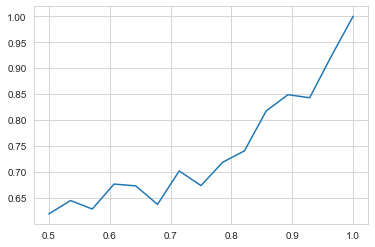

This took: 0:05:14.581645 s


In [39]:
env.stoachstic = True

time1=datetime.now()
means = []
x = np.linspace(0.5,1,15)
for i in x:
    env.p = i

    means += [valuate_model(env,stowage_Plans, n=100).mean()]

    
plt.plot(x, means)
plt.show()
print('This took:',datetime.now()-time1,'s')

In [285]:
agent = sarsa.SARSA(env, module_path)
agent.load_model(module_path+"20200729\\1827\\1827SARSA_L10_R14_Rf1_A5.p")

for info in agent.q_table["ModelParam"]:
    print(str(info)+'\t\t'+str(agent.q_table["ModelParam"][info]))

Algorithm		SARSA
GAMMA		0.999
ALPHA		0.1
Episodes		500000
EnvLanes:		10
EnvRows		14
VehicleData		[[ 0  1  2  3  4]
 [ 1  2  1  2  2]
 [ 1  1  0  0  1]
 [ 2  3  2  3  2]
 [ 5  5 -1 -1  2]
 [ 0  0  0  0  1]]
TrainingTime		3426.044958591461


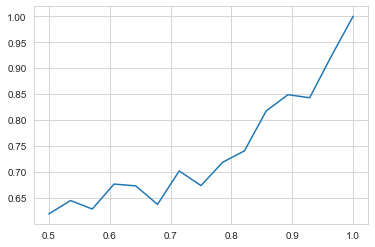

This took: 0:05:14.655279 s


In [41]:
env.stoachstic = True

time1=datetime.now()
means_2 = []
x = np.linspace(0.5,1,15)
for i in x:
    env.p = i

    means_2 += [valuate_model(env,stowage_Plans, n=100).mean()]

    
plt.plot(x, means)
plt.show()
print('This took:',datetime.now()-time1,'s')

In [42]:
env.stochastic= True
env.p = .8
env.reset()
agent.execute()
#print(env.loading_sequence)
evaluation = evaluator.evaluate(env.get_stowage_plan())
print(evaluation)
stowage_Plans_XX = stowage_Plans.copy()
stowage_Plans_XX += [evaluation]

#remove duplicates
stowage_Plans_XX = list(dict.fromkeys(stowage_Plans_XX))
stowage_Plans_XX.sort()

if len(stowage_Plans_XX) == len(stowage_Plans)+1:
    stowage_Plans_XX = stowage_Plans_XX[1:]

Mandatory Cargo Loaded: 1.0
Number of Shifts: 1.0
Space Utilisation: 0.925


In [43]:
#at which postion is the stowage plan of the agent. (maximal Performance 100%)
for ix,i in enumerate(stowage_Plans_XX):
    if i == evaluation:
        print(str(ix+1)+". Position of "+str(len(stowage_Plans))+ \
              "\t Performance of model: "+str((ix+1)/(len(stowage_Plans))))
        break

500. Position of 500	 Performance of model: 1.0


In [381]:
for i in stowage_Plans[100:]:
    print(i, '\n')

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 12.0
Space Utilisation: 0.9833333333333333 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 12.0
Space Utilisation: 0.9916666666666667 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.9333333333333333 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.95 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.9583333333333334 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.9666666666666667 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.975 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 11.0
Space Utilisation: 0.9833333333333333 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 10.0
Space Utilisation: 0.95 

Mandatory Cargo Loaded: 0.9166666666666666
Number of Shifts: 10.0
Space Utilisation: 0.

In [507]:
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu, kruskal

MannwhitneyuResult(statistic=405000.0, pvalue=9.419046171773485e-14)

In [52]:
agent = sarsa.SARSA(env, module_path)
agent.load_model(module_path+"20200729\\1827\\1827SARSA_L10_R14_Rf1_A5.p")

for info in agent.q_table["ModelParam"]:
    print(str(info)+'\t\t'+str(agent.q_table["ModelParam"][info]))

Algorithm		SARSA
GAMMA		0.999
ALPHA		0.1
Episodes		500000
EnvLanes:		10
EnvRows		14
VehicleData		[[ 0  1  2  3  4]
 [ 1  2  1  2  2]
 [ 1  1  0  0  1]
 [ 2  3  2  3  2]
 [ 5  5 -1 -1  2]
 [ 0  0  0  0  1]]
TrainingTime		3426.044958591461


In [445]:
random=stowage_Plans.copy()

In [830]:
env.stochastic= True
env.p = .6
best_sp = []

while len(best_sp)<200:
    env.reset()
    agent.execute()
    evaluation = evaluator.evaluate(env.get_stowage_plan())
    if evaluation not in random:
        best_sp += [evaluation]

In [831]:
dummy = random + best_sp
dummy.sort()

In [832]:
random_ranks = []
agent_ranks = []
for ix, i in enumerate(dummy):
    if i in best_sp:
        agent_ranks+=[ix]
    else:
        random_ranks+=[ix]
        
agent_ranks = np.array(agent_ranks)
random_ranks = np.array(random_ranks)

In [837]:
#print(mannwhitneyu(random_ranks, agent_ranks, alternative='two-sided'),'\n')
print(mannwhitneyu(random_ranks, agent_ranks, alternative='two-sided'))
print(ranksums(random_ranks,agent_ranks))
print(kruskal(random_ranks, agent_ranks))

MannwhitneyuResult(statistic=10331.0, pvalue=6.128868634596224e-17)
RanksumsResult(statistic=-8.3631522144819, pvalue=6.106434806099714e-17)
KruskalResult(statistic=69.9423149625934, pvalue=6.10643480610005e-17)


<Figure size 432x288 with 0 Axes>

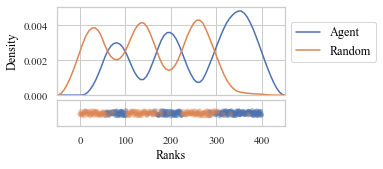

In [836]:
module_path = str(os.getcwd())+'\\out\\plots'
os.makedirs(module_path, exist_ok=True)


sns.set(style="whitegrid")
#sns.set(font_scale=1, rc={'text.usetex' : True})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.tight_layout()


#fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(2.6, 4))
bw = 50

fig = plt.figure(figsize=(5.1, 2.2))
#fig = plt.figure(figsize=(7.9, 3.3))

fig.tight_layout()
gs = fig.add_gridspec(4, 3)

fi_ax1 = fig.add_subplot(gs[0:3, :])
fi_ax2 = fig.add_subplot(gs[3, :],sharex=fi_ax1)


plt.setp(fi_ax1.get_xticklabels(), visible=False)
plt.setp(fi_ax2.get_xticklabels(), visible=True)


ax = sns.kdeplot(np.array(agent_ranks), bw=bw, clip=[0,len(dummy)],kernel='epa', ax=fi_ax1,label='Agent')
ax = sns.kdeplot(np.array(random_ranks),ax=ax , bw=bw, clip=[0,len(dummy)],kernel='epa',label='Random')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, box.y0 +0.5* box.height), fontsize=11*(1/0.9))

ax = sns.stripplot(np.array(agent_ranks),alpha=0.5, ax = fi_ax2,label='Agent')
ax = sns.stripplot(np.array(random_ranks),alpha=0.35, ax = ax, color=sns.color_palette("deep")[1],label='Random')
ax.set_xlim(-bw, len(dummy)+bw)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend below current axis
#leg = ax.legend(loc='upper left', bbox_to_anchor=(-0.013, -0.6),
#          fancybox=True, shadow=False, ncol=1, fontsize=11*(1/0.9))
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)

    
fi_ax1.set(ylabel='Density')
fi_ax2.set(xlabel='Ranks')
#fi_ax2.xaxis.set_label_coords(0.96, -0.72)
#plt.suptitle('Rank Comparison of stowage plans',x=0.5*0.9)
#plt.tight_layout()


plt.savefig(module_path + '\\denisity_p60prozent_bw50.pdf', dpi=600, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

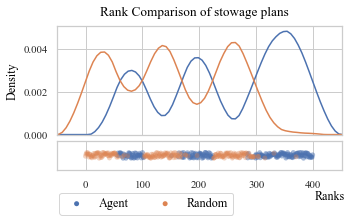

In [835]:
module_path = str(os.getcwd())+'\\out\\plots'
os.makedirs(module_path, exist_ok=True)


sns.set(style="whitegrid")
#sns.set(font_scale=1, rc={'text.usetex' : True})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})
plt.tight_layout()


#fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(2.6, 4))
bw = 50

fig = plt.figure(figsize=(5.1, 2.7))
#fig = plt.figure(figsize=(7.9, 3.3))

fig.tight_layout()
gs = fig.add_gridspec(4, 3)

fi_ax1 = fig.add_subplot(gs[0:3, :])
fi_ax2 = fig.add_subplot(gs[3, :],sharex=fi_ax1)


plt.setp(fi_ax1.get_xticklabels(), visible=False)
plt.setp(fi_ax2.get_xticklabels(), visible=True)


ax = sns.kdeplot(np.array(agent_ranks), bw=bw, clip=[0,len(dummy)],kernel='epa', ax=fi_ax1)
ax = sns.kdeplot(np.array(random_ranks),ax=ax , bw=bw, clip=[0,len(dummy)],kernel='epa')


ax = sns.stripplot(np.array(agent_ranks),alpha=0.5, ax = fi_ax2,label='Agent')
ax = sns.stripplot(np.array(random_ranks),alpha=0.35, ax = ax, color=sns.color_palette("deep")[1],label='Random')
ax.set_xlim(-bw, len(dummy)+bw)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
leg = ax.legend(loc='upper left', bbox_to_anchor=(-0.013, -0.6),
          fancybox=True, shadow=False, ncol=5, fontsize=11*(1/0.9))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

    
fi_ax1.set(ylabel='Density')
fi_ax2.set(xlabel='Ranks')
fi_ax2.xaxis.set_label_coords(0.96, -0.72)
plt.suptitle('Rank Comparison of stowage plans')

plt.savefig(module_path + '\\denisity_a.pdf', dpi=600, bbox_inches="tight")

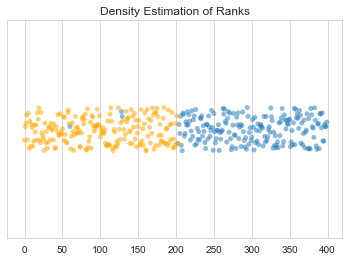

In [648]:
import seaborn as sns
bw = 50
sns.set_style('whitegrid')
#ax = sns.distplot(np.array(agent_ranks), label='Agent')
sns.stripplot(np.array(agent_ranks),alpha=0.5,dodge=True);
#ax = sns.distplot(np.array(random_ranks),ax=ax, label='Random')
sns.stripplot(np.array(random_ranks), color="orange",alpha=0.5,dodge=True)
plt.title('Density Estimation of Ranks')
ax.set_xlim(-bw, len(dummy)+bw)
plt.show()

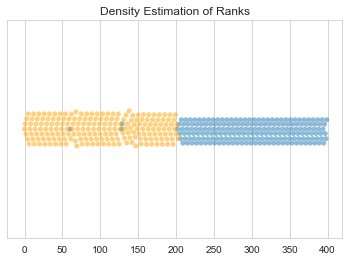

In [649]:
import seaborn as sns
bw = 50
sns.set_style('whitegrid')
#ax = sns.distplot(np.array(agent_ranks), label='Agent')
sns.swarmplot(np.array(agent_ranks),alpha=0.5);
#ax = sns.distplot(np.array(random_ranks),ax=ax, label='Random')
sns.swarmplot(np.array(random_ranks), color="orange",alpha=0.5)
plt.title('Density Estimation of Ranks')
ax.set_xlim(-bw, len(dummy)+bw)
plt.show()

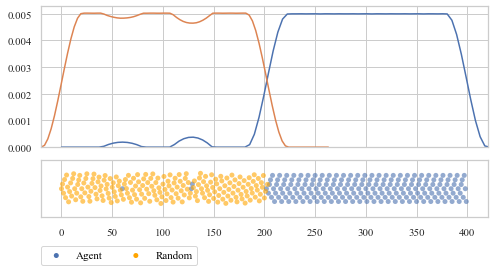

In [655]:
#fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(2.6, 4))
bw = 20

fig = plt.figure(figsize=(8, 4))
fig.tight_layout()
gs = fig.add_gridspec(3, 3)

fi_ax1 = fig.add_subplot(gs[0:2, :])
fi_ax2 = fig.add_subplot(gs[2, :],sharex=fi_ax1)


plt.setp(fi_ax1.get_xticklabels(), visible=False)
plt.setp(fi_ax2.get_xticklabels(), visible=True)


ax = sns.kdeplot(np.array(agent_ranks), bw=bw, clip=[0,len(dummy)],kernel='epa', ax=fi_ax1)
ax = sns.kdeplot(np.array(random_ranks),ax=ax , bw=bw, clip=[0,len(dummy)],kernel='epa')


ax = sns.swarmplot(np.array(agent_ranks),alpha=0.6, ax = fi_ax2,label='Agent')
ax = sns.swarmplot(np.array(random_ranks),alpha=0.6, ax = ax, color="orange",label='Random')
ax.set_xlim(-bw, len(dummy)+bw)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
leg = ax.legend(loc='upper left', bbox_to_anchor=(-0.013, -0.4),
          fancybox=True, shadow=False, ncol=5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

In [692]:
print(module_path)

C:\Users\braun\Documents\Masterarbeit\analysis\out\plots
